Data Set 1 for the BCI Competition IV

In [1]:
from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import loadmat
import mne

In [2]:
dat = loadmat('BCICIV_calib_ds1d.mat', struct_as_record=True)

In [3]:
dat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'mrk', 'cnt', 'nfo'])

In [4]:
sfreq = dat['nfo']['fs'][0][0][0][0]
EEGdata   = dat['cnt'].T
nchannels, nsamples = EEGdata.shape

chan_names = [s[0] for s in dat['nfo']['clab'][0][0][0]]

event_onsets  = dat['mrk'][0][0][0]
event_codes   = dat['mrk'][0][0][1]

labels = np.zeros((1, nsamples), int)
labels[0, event_onsets] = event_codes

cl_lab = [s[0] for s in dat['nfo']['classes'][0][0][0]]
cl1    = cl_lab[0]
cl2    = cl_lab[1]

# digitized electrode positions
xpos = dat['nfo']['xpos']
ypos = dat['nfo']['ypos']

nclasses = len(cl_lab)
nevents = len(event_onsets)

# Print some information
print('Shape of EEG:', EEGdata.shape)
print('Sample rate:', sfreq)
print('Number of channels:', nchannels)
print('Channel names:', chan_names)
print('Number of events:', len(event_onsets))
print('Event codes:', np.unique(event_codes))
print('Class labels:', cl_lab)
print('Number of classes:', nclasses)

Shape of EEG: (59, 190473)
Sample rate: 100
Number of channels: 59
Channel names: ['AF3', 'AF4', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'CFC7', 'CFC5', 'CFC3', 'CFC1', 'CFC2', 'CFC4', 'CFC6', 'CFC8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'CCP7', 'CCP5', 'CCP3', 'CCP1', 'CCP2', 'CCP4', 'CCP6', 'CCP8', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'PO1', 'PO2', 'O1', 'O2']
Number of events: 1
Event codes: [-1  1]
Class labels: ['left', 'right']
Number of classes: 2


In [5]:
# Dictionary to store the trials in, each class gets an entry
trials = {}

# The time window to extract for each trial, here 0.5 -- 2.5 seconds
win = np.arange(int(0.5*sfreq), int(2.5*sfreq))

# Length of the time window
nsamples = len(win)

# Loop over the classes (right, foot)
for cl, code in zip(cl_lab, np.unique(event_codes)):

    # Extract the onsets for the class
    cl_onsets = event_onsets[event_codes == code]

    # Allocate memory for the trials
    trials[cl] = np.zeros((nchannels, nsamples, len(cl_onsets)))

    # Extract each trial
    for i, onset in enumerate(cl_onsets):
        trials[cl][:,:,i] = EEGdata[:, win+onset]

# the dimensionality of the data (channels x time x trials)
print('Shape of trials[cl1]:', trials[cl1].shape)
print('Shape of trials[cl2]:', trials[cl2].shape)

Shape of trials[cl1]: (59, 200, 100)
Shape of trials[cl2]: (59, 200, 100)


In [6]:
%qtconsole

In [7]:
left_hand  = np.rollaxis(trials[cl1], 2, 0)
right_hand = np.rollaxis(trials[cl2], 2, 0)

In [8]:
left_hand.shape

(100, 59, 200)

In [9]:
data = np.concatenate([left_hand, right_hand])

In [10]:
# create labels
Y = np.concatenate([-np.ones(left_hand.shape[0]),
                     np.ones(right_hand.shape[0])])

## Create MNE structure

In [11]:
import mne

We need the following information to create MNE structure:
   - data ([ndarray]): [trials x chans x samples]
   - y ([ndarray]):    [class label array  [1, labels]]
   - sfreq ([int]):    [sampling frequency]
   - event_id ([dict]): [{1 :'pos', -1 : 'neg'} - class labels id]
   - chan_names ([list]): [channel names in a list of strings]                      

In [12]:
n_channels = 59

# Initialize an info structure
info = mne.create_info(
        ch_names = chan_names,
        ch_types = ['eeg']*nchannels,
        sfreq    = sfreq )

print('Event created :', info)

Event created : <Info | 7 non-empty values
 bads: []
 ch_names: AF3, AF4, F5, F3, F1, Fz, F2, F4, F6, FC5, FC3, FC1, FCz, FC2, ...
 chs: 59 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 50.0 Hz
 meas_date: unspecified
 nchan: 59
 projs: []
 sfreq: 100.0 Hz
>


In [13]:
# digitized electrode positions
xpos = dat['nfo']['xpos'][0][0]
ypos = dat['nfo']['ypos'][0][0]

In [14]:
layout_pos = np.concatenate([xpos, ypos], axis = 1)
layout_pos

array([[-0.20109028,  0.68656518],
       [ 0.20109028,  0.68656518],
       [-0.48547489,  0.52547424],
       [-0.32894737,  0.46520183],
       [-0.16535231,  0.43208641],
       [ 0.        ,  0.421549  ],
       [ 0.16535231,  0.43208641],
       [ 0.32894737,  0.46520183],
       [ 0.48547489,  0.52547424],
       [-0.60591541,  0.27165704],
       [-0.39919579,  0.23384348],
       [-0.19765935,  0.21394494],
       [ 0.        ,  0.20773757],
       [ 0.19765935,  0.21394494],
       [ 0.39919579,  0.23384348],
       [ 0.60591541,  0.27165704],
       [-0.74834683,  0.15177169],
       [-0.52472976,  0.12553103],
       [-0.30963911,  0.11086096],
       [-0.10226303,  0.10426648],
       [ 0.10226303,  0.10426648],
       [ 0.30963911,  0.11086096],
       [ 0.52472976,  0.12553103],
       [ 0.74834683,  0.15177169],
       [-0.87719298,  0.        ],
       [-0.64569058,  0.        ],
       [-0.421549  ,  0.        ],
       [-0.20773757,  0.        ],
       [ 0.        ,

In [15]:
layout = mne.channels.generate_2d_layout(
    xy = layout_pos,
    ch_names=chan_names,
    name ='EEG custom layout',
    )

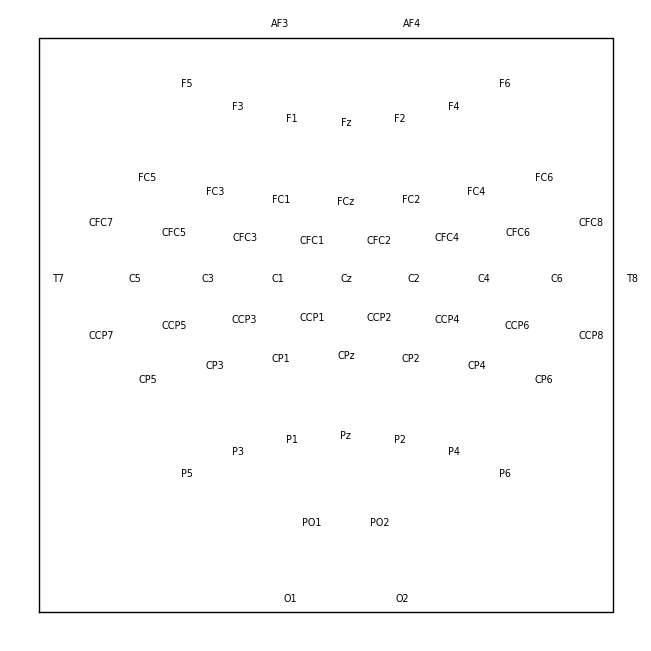

In [16]:
layout.plot();

### MNE events
the events array should contain the following information
[sample onsets, zeros, labels]

In [17]:
event_id = dict(left = -1, right = 1)

In [18]:
# Create an event matrix: events with alternating event codes
eventLength = Y.shape[0]
ev = [i*sfreq*3 for i in range(eventLength)]

events = np.column_stack((np.array(ev,  dtype = int),
                          np.zeros(eventLength,  dtype = int),
                          np.array(Y,  dtype = int)))

In [19]:
events

array([[    0,     0,    -1],
       [  300,     0,    -1],
       [  600,     0,    -1],
       [  900,     0,    -1],
       [ 1200,     0,    -1],
       [ 1500,     0,    -1],
       [ 1800,     0,    -1],
       [ 2100,     0,    -1],
       [ 2400,     0,    -1],
       [ 2700,     0,    -1],
       [ 3000,     0,    -1],
       [ 3300,     0,    -1],
       [ 3600,     0,    -1],
       [ 3900,     0,    -1],
       [ 4200,     0,    -1],
       [ 4500,     0,    -1],
       [ 4800,     0,    -1],
       [ 5100,     0,    -1],
       [ 5400,     0,    -1],
       [ 5700,     0,    -1],
       [ 6000,     0,    -1],
       [ 6300,     0,    -1],
       [ 6600,     0,    -1],
       [ 6900,     0,    -1],
       [ 7200,     0,    -1],
       [ 7500,     0,    -1],
       [ 7800,     0,    -1],
       [ 8100,     0,    -1],
       [ 8400,     0,    -1],
       [ 8700,     0,    -1],
       [ 9000,     0,    -1],
       [ 9300,     0,    -1],
       [ 9600,     0,    -1],
       [ 9

In [20]:
# The time window (in samples) to extract for each trial, here 0.5 -- 2.5 seconds
tmin = 0.5

# Create the :class:`mne.EpochsArray` object
epochs = mne.EpochsArray(data, info, events, tmin, event_id)

Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated


In [21]:
epochs.get_data().shape

(200, 59, 200)

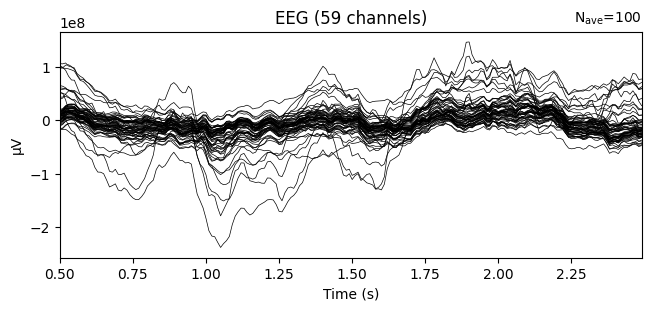

In [22]:
epochs['left'].average().plot();

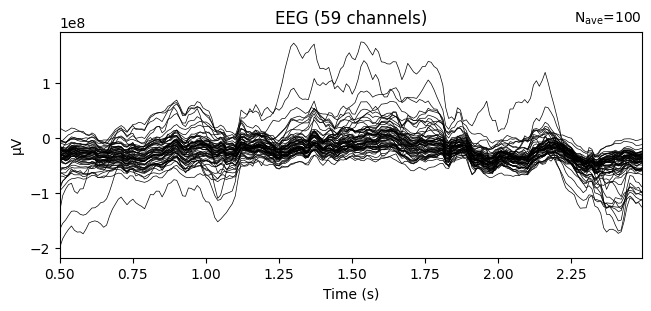

In [23]:
epochs['right'].average().plot();

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


C:\Users\Greatest Pleasure\AppData\Local\Temp\ipykernel_10300\2204970765.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  epochs.plot_psd();
C:\Users\Greatest Pleasure\AppData\Roaming\Python\Python312\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


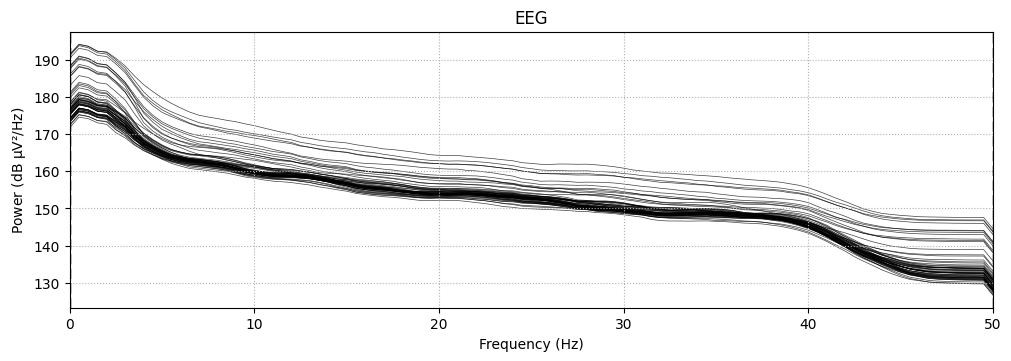

In [24]:
epochs.plot_psd();

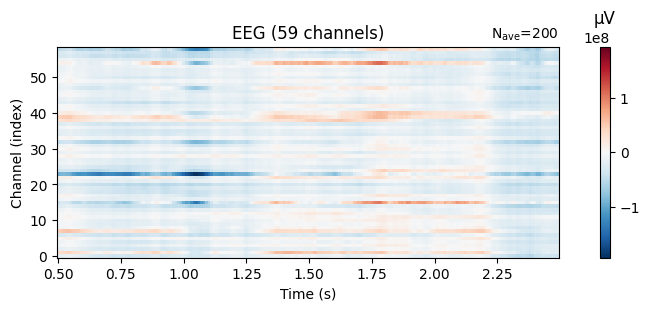

In [25]:
epochs.average().plot_image();

In [26]:
epochs.filter(l_freq=8, h_freq=32)

Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 32.00 Hz
- Upper transition bandwidth: 8.00 Hz (-6 dB cutoff frequency: 36.00 Hz)
- Filter length: 165 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    0.8s
[Parallel(n_job

<EpochsArray | 200 events (all good), 0.5 – 2.49 s (baseline off), ~18.1 MB, data loaded,
 'left': 100
 'right': 100>

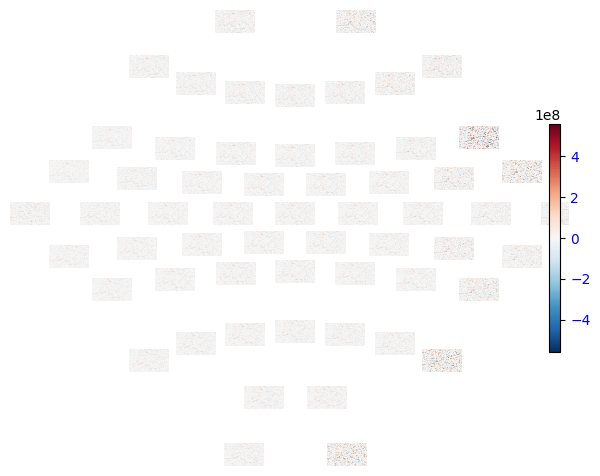

In [27]:
epochs.plot_topo_image(layout=layout,
                       fig_facecolor='w', font_color='b');

In [42]:
from scipy.signal import welch
import numpy as np
def compute_psd(eeg_data, frequency_range, fs=100, nperseg=50):
    epochs, channels, _ = eeg_data.shape
    psd = np.zeros((epochs, channels))

    for epoch in range(epochs):
        for channel in range(channels):
            freqs, power_spectrum = welch(eeg_data[epoch, channel], fs=fs, nperseg=nperseg)
            freq_min, freq_max = frequency_range
            indices = np.logical_and(freqs >= freq_min, freqs <= freq_max)
            psd[epoch, channel] = np.mean(power_spectrum[indices])

    return psd

# Example frequency bands (adjust as needed)
frequency_bands = {
    #'delta': (1, 4),
    #'theta': (4, 8),
    'alpha': (8, 12),
    'beta': (13, 30)
}

# Compute PSD features for each frequency band
def extract_band_features(eeg_data, bands, fs=100, nperseg=50):
    features = []
    for band_name, freq_range in bands.items():
        psd_band = compute_psd(eeg_data, frequency_range=freq_range, fs=fs, nperseg=nperseg)
        features.append(psd_band)
    # Stack features for all bands
    return np.hstack(features)

# Prepare data for feature extraction
X = epochs.get_data()  # Shape: (200, 59, 200)
X_features = extract_band_features(X, frequency_bands)

In [36]:
X_features.shape


(200, 118)

In [43]:
y = epochs.events[:, -1]
y.shape

(200,)

In [52]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

# Example data placeholders (replace with actual feature and label arrays)
features = X_features  # Extracted PSD features
label_array = y  # Corresponding labels

# Split into training and testing sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(features, label_array, test_size=0.2, random_state=42)

# Define classifiers and parameter grids for each model
classifiers = {
    'RandomForest': (
        RandomForestClassifier(),
        {
            'classifier__n_estimators': [10, 30, 50],
            'classifier__max_depth': [3, 6, 9],
            'classifier__max_features': ['sqrt', 0.3],
            'classifier__min_samples_split': [5, 10],
            'classifier__min_samples_leaf': [2, 4]
        })
    # Add other models if needed
}

# KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=0)

# Dictionary to store the best validation scores for each classifier
best_models = {}

# Loop through each classifier
for model_name, (clf, params_grid) in classifiers.items():
    print(f"\nTraining {model_name} model...")

    # Set up pipeline with scaling, PCA, and classifier
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=0.95)),  # Keeps 95% of the variance in the data
        ('classifier', clf)
    ])

    # Grid search with KFold CV
    model = GridSearchCV(pipe, params_grid, cv=kf)

    # Fit the model on the training set
    model.fit(X_train, y_train)

    # Store the best model
    final_model = model.best_estimator_
    best_models[model_name] = final_model

    # Evaluate the best model on the hold-out test set
    y_pred = final_model.predict(X_test)
    
    # Calculate training and test accuracies
    train_accuracy = final_model.score(X_train, y_train)
    test_accuracy = final_model.score(X_test, y_test)
    
    print(f"\nBest {model_name} Model Performance:")
    print(f"Training Accuracy: {train_accuracy:.2f}")
    print(f"Test Accuracy: {test_accuracy:.2f}")
    print(classification_report(y_test, y_pred))

# Output the best models for each classifier and their validation scores
for model_name, final_model in best_models.items():
    print(f"\nBest model for {model_name}:")
    print(final_model)



Training RandomForest model...

Best RandomForest Model Performance:
Training Accuracy: 0.88
Test Accuracy: 0.60
              precision    recall  f1-score   support

          -1       0.63      0.57      0.60        21
           1       0.57      0.63      0.60        19

    accuracy                           0.60        40
   macro avg       0.60      0.60      0.60        40
weighted avg       0.60      0.60      0.60        40


Best model for RandomForest:
Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=0.95)),
                ('classifier',
                 RandomForestClassifier(max_depth=3, min_samples_leaf=4,
                                        min_samples_split=5,
                                        n_estimators=30))])


In [57]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

# Example data placeholders (replace with actual feature and label arrays)
features = X_features  # Extracted PSD features
label_array = y  # Corresponding labels

# Split into training and testing sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(features, label_array, test_size=0.3, random_state=0)

# Define classifiers and parameter grids for each model
classifiers = {
    'MLP': (
        MLPClassifier(max_iter=500),
        {'classifier__hidden_layer_sizes': [(20,), (30,), (30, 30), (20, 30)],  # Expand hidden layers
         'classifier__alpha': [0.001, 0.01, 0.1, 0.3,0.5,0.7]}  # Increase alpha range for better regularization
    )
    # Add other models if needed
}

# KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=0)

# Dictionary to store the best validation scores for each classifier
best_models = {}

# Loop through each classifier
for model_name, (clf, params_grid) in classifiers.items():
    print(f"\nTraining {model_name} model...")

    # Set up pipeline with scaling, PCA, and classifier
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=0.95)),  # Keeps 95% of the variance in the data
        ('classifier', clf)
    ])

    # Grid search with KFold CV
    model = GridSearchCV(pipe, params_grid, cv=kf)

    # Fit the model on the training set
    model.fit(X_train, y_train)

    # Store the best model
    final_model = model.best_estimator_
    best_models[model_name] = final_model

    # Evaluate the best model on the hold-out test set
    y_pred = final_model.predict(X_test)
    
    # Calculate training and test accuracies
    train_accuracy = final_model.score(X_train, y_train)
    test_accuracy = final_model.score(X_test, y_test)
    
    print(f"\nBest {model_name} Model Performance:")
    print(f"Training Accuracy: {train_accuracy:.2f}")
    print(f"Test Accuracy: {test_accuracy:.2f}")
    print(classification_report(y_test, y_pred))

# Output the best models for each classifier and their validation scores
for model_name, final_model in best_models.items():
    print(f"\nBest model for {model_name}:")
    print(final_model)



Training MLP model...


C:\Users\Greatest Pleasure\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Greatest Pleasure\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Greatest Pleasure\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Greatest Pleasure\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the 


Best MLP Model Performance:
Training Accuracy: 1.00
Test Accuracy: 0.65
              precision    recall  f1-score   support

          -1       0.62      0.69      0.66        29
           1       0.68      0.61      0.64        31

    accuracy                           0.65        60
   macro avg       0.65      0.65      0.65        60
weighted avg       0.65      0.65      0.65        60


Best model for MLP:
Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=0.95)),
                ('classifier',
                 MLPClassifier(alpha=0.001, hidden_layer_sizes=(30,),
                               max_iter=500))])


C:\Users\Greatest Pleasure\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [45]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

# Example data placeholders (replace with actual feature and label arrays)
features = X_features  # Extracted PSD features
label_array = y  # Corresponding labels

# Split into training and testing sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(features, label_array, test_size=0.2, random_state=42)

# Define classifiers and parameter grids for each model
classifiers = {
    'RandomForest': (
        RandomForestClassifier(),
        {'classifier__n_estimators': [50, 100, 150],
         'classifier__max_depth': [5, 10, 20],
         'classifier__min_samples_split': [5, 10]}  # Add min_samples_split for regularization
    ),
    'SVM': (
        SVC(),
        {'classifier__C': [0.1, 1, 10, 100],
         'classifier__kernel': ['linear', 'rbf']}
    ),
    'GradientBoosting': (
        GradientBoostingClassifier(),
        {'classifier__n_estimators': [50, 100, 150],
         'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2]}  # Expand the learning rate range
    ),
    'MLP': (
        MLPClassifier(max_iter=500),
        {'classifier__hidden_layer_sizes': [(15,), (20,), (15, 15), (30, 15)],  # Expand hidden layers
         'classifier__alpha': [0.0001, 0.001, 0.01, 0.1]}  # Increase alpha range for better regularization
    )
}

# KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=0)

# Dictionary to store the best validation scores for each classifier
best_models = {}

# Loop through each classifier
for model_name, (clf, params_grid) in classifiers.items():
    print(f"\nTraining {model_name} model...")

    # Set up pipeline with scaling, PCA, and classifier
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=0.95)),  # Keeps 95% of the variance in the data
        ('classifier', clf)
    ])

    # Grid search with KFold CV
    model = GridSearchCV(pipe, params_grid, cv=kf)

    # Fit the model on the training set
    model.fit(X_train, y_train)

    # Store the best model
    final_model = model.best_estimator_
    best_models[model_name] = final_model

    # Evaluate the best model on the hold-out test set
    y_pred = final_model.predict(X_test)
    
    # Calculate training and test accuracies
    train_accuracy = final_model.score(X_train, y_train)
    test_accuracy = final_model.score(X_test, y_test)
    
    print(f"\nBest {model_name} Model Performance:")
    print(f"Training Accuracy: {train_accuracy:.2f}")
    print(f"Test Accuracy: {test_accuracy:.2f}")
    print(classification_report(y_test, y_pred))

# Output the best models for each classifier and their validation scores
for model_name, final_model in best_models.items():
    print(f"\nBest model for {model_name}:")
    print(final_model)



Training RandomForest model...

Best RandomForest Model Performance:
Training Accuracy: 1.00
Test Accuracy: 0.47
              precision    recall  f1-score   support

          -1       0.50      0.38      0.43        21
           1       0.46      0.58      0.51        19

    accuracy                           0.47        40
   macro avg       0.48      0.48      0.47        40
weighted avg       0.48      0.47      0.47        40


Training SVM model...

Best SVM Model Performance:
Training Accuracy: 0.70
Test Accuracy: 0.55
              precision    recall  f1-score   support

          -1       0.59      0.48      0.53        21
           1       0.52      0.63      0.57        19

    accuracy                           0.55        40
   macro avg       0.55      0.55      0.55        40
weighted avg       0.56      0.55      0.55        40


Training GradientBoosting model...

Best GradientBoosting Model Performance:
Training Accuracy: 0.99
Test Accuracy: 0.72
              

C:\Users\Greatest Pleasure\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Greatest Pleasure\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Greatest Pleasure\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Greatest Pleasure\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the 


Best MLP Model Performance:
Training Accuracy: 1.00
Test Accuracy: 0.60
              precision    recall  f1-score   support

          -1       0.65      0.52      0.58        21
           1       0.57      0.68      0.62        19

    accuracy                           0.60        40
   macro avg       0.61      0.60      0.60        40
weighted avg       0.61      0.60      0.60        40


Best model for RandomForest:
Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=0.95)),
                ('classifier',
                 RandomForestClassifier(max_depth=10, min_samples_split=5))])

Best model for SVM:
Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=0.95)),
                ('classifier', SVC(C=10, kernel='linear'))])

Best model for GradientBoosting:
Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=0.95)),
                ('classifier', GradientBoostingClassifier(n_estimators=50))])

Best model for MLP:
Pipeline(

C:\Users\Greatest Pleasure\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
